# Moneyball: Linear Regression will get you to the Playoffs

## _"When I first came into baseball, people didn't want to hear that a team was a business. But it is. And the better the business is run, the healthier the team on the field is going to be." - Billy Beane, Former General Manager of Oaklanda A's_

<p><img style="float: left;margin:5px 20px 20px 10px" src="images/billy-beane.jpg" width=250></p>

In early 2019, I read "Moneyball" for the first time. The book, written by Michael Lewis, follows the now well known story of Billy Beane _(seen on the left)_, General Manager of the Oakland A's in the early 2000's, who faced the challenge of building and running a championship-level team without the budget to purchase top-tier talent. To overcome this challenge, he recruits Paul DePodesta, a young Harvard grad with a degree in economics, to use analytics to identify undervalued players that could be drafted or traded for below market value.

### This Jupyter notebook explores part of the analysis that Beane and Podesta, and many more sports quants today, explored: what can we do to get more wins and make it to the playoffs?

_(Analysis adapted from [this Towards Data Science Medium article](https://towardsdatascience.com/moneyball-linear-regression-76034259af5e) on Linear Regression and Baseball Analytics)._

In [1]:
## Load packages we will need for reshaping the data.
import pandas as pd
import numpy as np

## Load the data.
df = pd.read_csv('datasets/baseball.csv')

## I'm dropping columns that deal with playoff rankings, season rankings, and number of games played; we won't be using these for the analysis.
df.drop(['RankSeason','RankPlayoffs','G'], axis=1, inplace=True)
print(df.head())

  Team League  Year   RS   RA   W    OBP    SLG     BA  Playoffs   OOBP   OSLG
0  ARI     NL  2012  734  688  81  0.328  0.418  0.259         0  0.317  0.415
1  ATL     NL  2012  700  600  94  0.320  0.389  0.247         1  0.306  0.378
2  BAL     AL  2012  712  705  93  0.311  0.417  0.247         1  0.315  0.403
3  BOS     AL  2012  734  806  69  0.315  0.415  0.260         0  0.331  0.428
4  CHC     NL  2012  613  759  61  0.302  0.378  0.240         0  0.335  0.424


### Let's get oriented with how to read the metrics we are going to be looking at in this dataset.

<p><img style="float: right;margin:20px 20px 20px 20px" src="images/baseball.jpg" width=400></p>

* __W__: The number of Wins for the team that season.
* __RS__: The number of Runs Scored by the team that season.
* __RA__: The number of Runs Allowed _(points scored against the team)_.
* __OBP__: On-Base Percentage _(percentage of time players gets onto any base)_.
* __OOBP__: Opponent's On-Base Percentage.
* __SLG__: Slugging Percentage _(how far the team's batters make it around the base when they hit the ball)_.
* __OSLG__: Opponent's Slugging Percentage.
* __BA__: Batting Average _(The number of hits divided by number of at bats; likelihood the player will hit the ball)_.

### Intuitively, there is one feature we are going to want to create here - Runs Difference. 

Using Runs Scored _(points the team makes)_ and subtracting Runs Allowed _(points the competing teams make)_, we can calculated a new column called 'Runs Difference'. This column will come in handy as it reduces the dimensionality of these two columns into one that can be correlated with Wins -- more on that soon. Let's create Runs Difference ['RD'] now.

In [2]:
## Create new column: Runs Difference (df['RD']).
df['RD'] = df['RS'] - df['RA']


Now we are ready to look at our data. Putting on our General Manager hat, we want to know what it is going to take to get our team to playoffs this year. Let's see if we can identify what are the attributes of playoffs-worthy team.

Let's start by creating a scatterplot where each dot is a team's end year stats for a specific season. The number of Runs Scored will be on the Y axis, and the number of Wins will be on the X axis. Let's say we feel confident that a team that wins at least 100 games will have a high chance of entering into the playoffs.

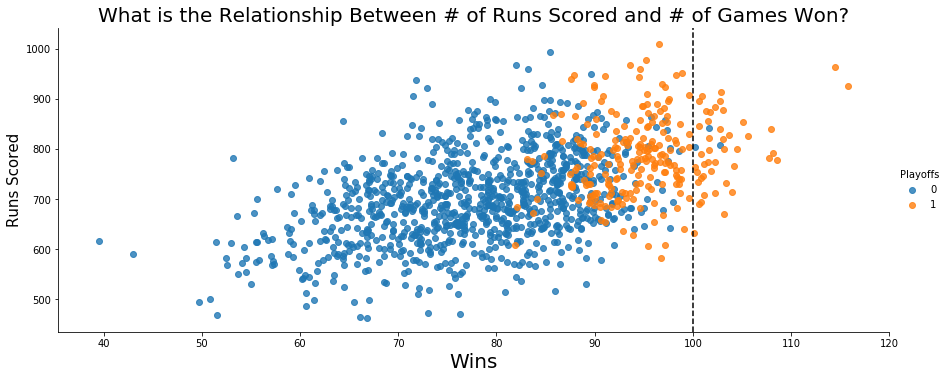

In [3]:
## Import Matplotlib and Seaborn to start exploratory data analysis.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Plot a scatter of Runs Scored vs. Wins.
sns.lmplot(x = "W", y = "RS", fit_reg = False, hue = "Playoffs", data=df, height=5, aspect=2.5,x_jitter=0.5)
plt.xlabel("Wins", fontsize = 20)
plt.ylabel("Runs Scored", fontsize = 15)
plt.axvline(100, 0, 1, color = "Black", ls = '--')
plt.title('What is the Relationship Between # of Runs Scored and # of Games Won?', fontsize = 20)
plt.show()

### Okay, we are learning a couple things here. 

* __First, winning 100 games is a good stretch goal for teams with playoffs aspirations.__ There are many teams that have gotten into the playoffs that won somewhere between 90 - 100 games, but only 2 teams in the dataset _did not_ make the playoffs after winning over 100 games. Teams that win over 100 games have a high likelihood of making the playoffs.
* Second, there seems to be some correlation between Wins and the number of Runs Scored, __but it doesn't look like a tight linear relationship yet.__ Some teams scored less than 700 runs but won over 90 games, while other teams score more than 800 runs but won under 80 games. There is some noise in the distribution.

One thing this scatterplot is not taking into account is _the number of runs the other team scored_. For generating wins, it doesn't matter if you score 1 point or 10 -- you just need to score more than the other team!

### Let's recreate this scatterplot. This time, let's use Runs Difference, since that feature accounts for both the Runs Scored and Runs Allowed by teams across the season.

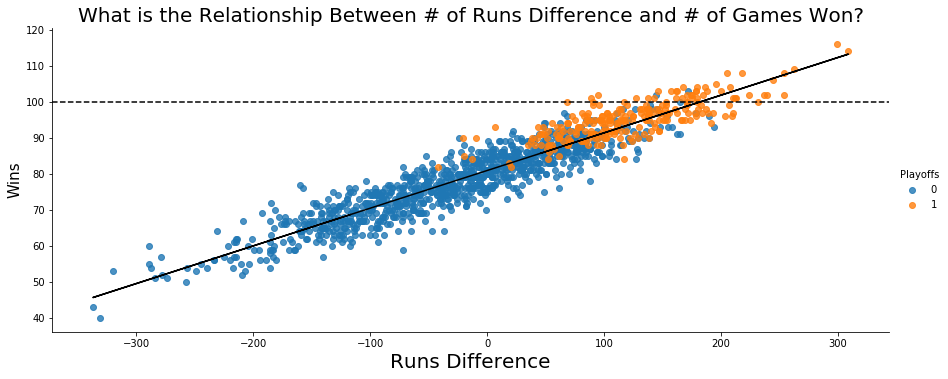

In [4]:
## Convert df['RD'], DF['W'] into numpy arrays. Calculate slope and intercept.
x = np.array(df.RD)
y = np.array(df.W)
slope, intercept = np.polyfit(x, y, 1)
abline_values = [slope * i + intercept for i in x]

## Plot a scatter of Wins vs. Run Differences, the slope of the line, and the "100 Wins" cutoff.
sns.lmplot(x = "RD", y = "W", fit_reg = False, hue = "Playoffs", data=df, height=5, aspect=2.5,x_jitter=0.5)
plt.xlabel("Runs Difference", fontsize = 20)
plt.ylabel("Wins", fontsize = 15)
plt.plot(x, abline_values, 'Black')
plt.axhline(100, 0, 1, color = "Black", ls = '--')
plt.title('What is the Relationship Between # of Runs Difference and # of Games Won?', fontsize = 20)
plt.show()

### Nice! This is a much tighter, linear distribution. 

Runs Difference seem to have a meaningful relationship with the number of wins. While most of our "100 Wins" teams are scoring 150 or more runs than they allow, the first cluster of playoff teams start showing up around a Runs Difference score of 50~.

Let's dive a little deeper into the relationship between Wins and Runs Difference to confirm what we are seeing in this visual.

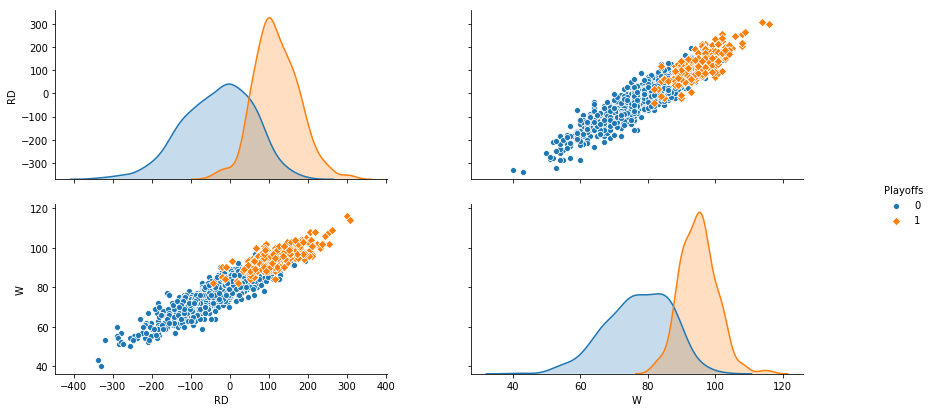

In [5]:
## Plot SNS pair plots to see the difference in distributions for playoff seasons vs. no playoff seasons.
corrcheck = df[['RD', 'W', 'Playoffs']]
g = sns.pairplot(corrcheck, hue = 'Playoffs', vars=["RD", "W"], markers=["o","D"])
g.fig.set_size_inches(14,6)

In [6]:
## Print the Pearson correlation.
corrcheck.corr(method='pearson')

,RD,W,Playoffs
RD,1.000000,0.937851,0.581094
W,0.937851,1.000000,0.616757
Playoffs,0.581094,0.616757,1.000000


Runs Difference has a strong positive correlation with the number of Wins (Pearson score: 0.938). Wins has a moderately strong position correlation with whether or not a team makes the playoffs (Pearson score: 0.617).

### Stringing the two statements together: if a baseball team can score more points than they allow the other team to score, they will certainly win more games, and be more likely to make it to the playoffs.

Great! However, a 10-year-old child could reach the same conclusion on their own without looking at any data. We need to dig deeper to justify getting to wear our fictional General Manager hat.

So let's dig down a layer: if Runs Difference correlates strong to the number of Wins, and Runs Difference is just the difference of Runs Scored less the number of Runs Allowed, what are the statistics that correlate with _(and potentially influence the performance of)_ Runs Difference, Runs Scored, and Runs Allowed?

In [7]:
## Correlation with 'RD','RS','RA', and other metrics in the dataset that measure the performance of the team and opponent teams.
df[['RD','RS','RA','OBP','BA','SLG','OSLG','OOBP']].corr(method='pearson')

,RD,RS,RA,OBP,BA,SLG,OSLG,OOBP
RD,1.000000,0.546294,-0.567048,0.506379,0.436943,0.422865,-0.586227,-0.632871
RS,0.546294,1.000000,0.380139,0.900492,0.827000,0.918740,0.193426,0.133981
RA,-0.567048,0.380139,1.000000,0.326360,0.330764,0.436527,0.909319,0.910344
OBP,0.506379,0.900492,0.326360,1.000000,0.851958,0.790910,0.153372,0.120349
BA,0.436943,0.827000,0.330764,0.851958,1.000000,0.790481,0.227808,0.187108
SLG,0.422865,0.918740,0.436527,0.790910,0.790481,1.000000,0.210423,0.143861
OSLG,-0.586227,0.193426,0.909319,0.153372,0.227808,0.210423,1.000000,0.830902
OOBP,-0.632871,0.133981,0.910344,0.120349,0.187108,0.143861,0.830902,1.000000


To reorient you: we are looking at a matrix of correlation between Runs Difference, Runs Scored, and Runs Allowed [RD, RS, RA], and are checking them against metrics that track how a team performs in game -- On-Base Percentage, Batting Average, Slugging Percentage, Opponent's Slugging Percentage, and Opponent's On-Base Percentage [OBP, BA, SLG, OSLG, OOBP].

### Not surprisingly, On Base Percentage and Slugging Percentage (for both the team and the opponent) have the strongest correlations with Runs Scored and Runs Allowed.

<p><img style="float: right;margin:20px 20px 20px 20px" src="images/on-base.jpeg" width=400></p>

These two in game metrics are tracking who gets on base, and how far around the bases they get -- these things are tightly related with the number of players that make it all the way around the bases and score a run.

Batting Average is a good-but-less-strong predictor of how Runs Scored. This may seem like a simple statement, but this discovey felt pretty counterintuitive in the early 2000's when Beane and Podesta began applying these types of statistical views to baseball management. Traditionally, scouts looked at Batting Average as a statistic of importance in measuring a player's performance. It turns out it's less important how often a player hits the ball, and more important how many times they get on base!

This gives us a pretty good idea of what kind of features we want to use to build our predictive linear models. But just to look at it from another perspective, let's use decision trees to show which features may have more importance over the predictive power of our linear models.

Runs Difference : [0.17569434 0.18213653 0.17289023 0.18886819 0.28041071]
Runs Scored : [0.19692696 0.20653107 0.19303256 0.19762488 0.20588453]
Runs Allowed : [0.18415846 0.20433154 0.1933076  0.20850773 0.20969467]


Text(0.04, 0.5, 'Statistic')

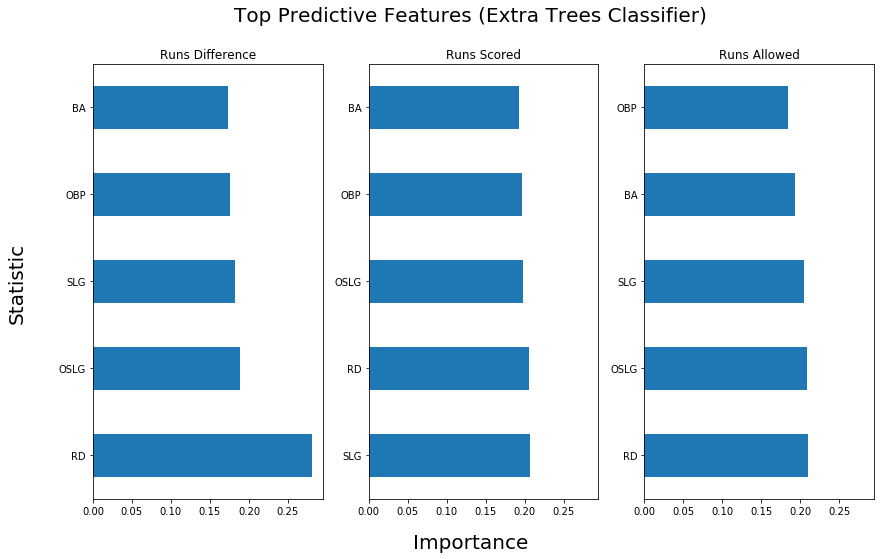

In [8]:
from sklearn.ensemble import ExtraTreesClassifier

## Dropping NA values for simplicity to prevent errors in decision trees.
moneyball = df.dropna()

## Prepare X and Y data.
X = moneyball.iloc[:,np.r_[6:9,11:13]]     #predictor columns
RD = moneyball.iloc[:,-1]                  #target column 1, runs difference
RS = moneyball.iloc[:,3]                   #target column 2, runs scored
RA = moneyball.iloc[:,4]                   #target column 3, runs allowed

## Create Subplot with three columns.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, sharex=True)

## Create lists to iterate through multiple y values and axs to plot the feature importance of OBP, SLG, and BA.
y_list = [RD, RS, RA]
axs = [ax1, ax2, ax3]
subtitles = ['Runs Difference', 'Runs Scored', 'Runs Allowed']

## Loop through to create subplots, using count to index y_list, axs, and subtitles.
count = 0
for y in y_list:
    model = ExtraTreesClassifier(n_estimators=100)
    model.fit(X,y)
    print(subtitles[count], ":", model.feature_importances_)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(5).plot(kind='barh', ax=axs[count], figsize = (14,8))
    axs[count].set_title(subtitles[count])
    count += 1

## Applying supertitles and labels for all subplots.
fig.suptitle('Top Predictive Features (Extra Trees Classifier)', fontsize = 20)
fig.text(0.5, 0.04, 'Importance', ha='center',size=20)
fig.text(0.04, 0.5, 'Statistic', va='center', rotation='vertical',size=20)


Intruiguing. Using an Extra Trees Classifier approach, it seems to be suggestioning that an opponent's batting performance may affect the number of Runs Scored by a team and similarly, that a team's batting performance may affect the number of Runs Allowed.

### While this looks interesting, my gut tells me this may be conflated with another variable. 

For example, it's possible that teams that bat well also defend well, which would influence the number of runs they allow. This is interesting to see mapped out, but I don't think this information necessarily makes me want to deviate from the correlated features that showed up in the Pearson matrix.

Let's move forward and build models based on the intuition we derived from the Pearson matrix.

In [9]:
from sklearn import linear_model

## Regression for Runs.
Runs_X, Runs_y = moneyball[['OBP','SLG']].values, moneyball[['RS']].values
Runs = linear_model.LinearRegression()
Runs.fit(Runs_X, Runs_y)
print('Runs Scored:\n','Intercept:',Runs.intercept_,'\n','Coefficients:',Runs.coef_,'\n')

# Regression for Runs Allowed.
RunsAllowed_X, RunsAllowed_y = moneyball[['OOBP','OSLG']].values, moneyball[['RA']].values
RunsAllowed = linear_model.LinearRegression()
RunsAllowed.fit(RunsAllowed_X, RunsAllowed_y)
print('Runs Allowed:\n','Intercept:',RunsAllowed.intercept_,'\n','Coefficients:',RunsAllowed.coef_,'\n')

## Regression for Wins.
Wins_X, Wins_y = moneyball[['RD']].values, moneyball[['W']].values
Wins = linear_model.LinearRegression()
Wins.fit(Wins_X, Wins_y)
print('Wins Achieved:\n','Intercept:',Wins.intercept_,'\n','Coefficients:',Wins.coef_)


Runs Scored:
 Intercept: [-912.64985706] 
 Coefficients: [[2844.83804273 1731.71025319]] 

Runs Allowed:
 Intercept: [-877.60505711] 
 Coefficients: [[2864.59846262 1632.76010215]] 

Wins Achieved:
 Intercept: [80.95714286] 
 Coefficients: [[0.10102321]]


<p><img style="float: right;margin:20px 20px 20px 20px" src="images/red-sox.png" width=300></p>

### Okay! We have our linear models built. We have fit: 
* A predictive model for Runs Scored using the features On-Base Percentage and Slugging Percentage; 
* A predictive model for Runs Allowed using the features Opponent's On-Base Percent and Opponent's Slugging Percentage; 
* And, finally, a predictive model for Wins using our predictions of Runs Scored and Runs Allowed.

### Now let's have some fun: imagine the Boston Red Sox hired us before the start of the 2019 season, and we wanted to see if our model has predictive power on the results for the prior season.

Based on the end of season metrics, how well does this model predict the Runs Scored, Runs Allowed, and Wins for the Red Sox in the 2018 season?

In [10]:
print("Boston 2018 Season Predictions:\n")

## OBP, SLG, BA: https://www.baseball-reference.com/teams/BOS/2018.shtml
## OOBP, OSLG: http://www.espn.com/mlb/stats/team/_/stat/batting/year/2018/seasontype/2

OBP = 0.339
SLG = 0.453
OOBP = 0.318
OSLG = 0.409

## First, predict Runs Scored with OBP and SLG. Second, predict Runs Allowed with OOBP, OSLG. Save results.
print("Runs Prediction:", Runs.predict([[OBP,SLG]])[0,0])
print("Runs Allowed Prediction:",RunsAllowed.predict([[OOBP,OSLG]])[0,0])

Runs_Pred = Runs.predict([[OBP,SLG]])[0,0]
RunsAllowed_Pred = RunsAllowed.predict([[OOBP,OSLG]])[0,0]
RunsDifference_Pred = Runs_Pred - RunsAllowed_Pred

## Using the results of Runs Scored and Runs Allowed predictions, predict the number of wins in the season.
print("Wins Prediction:", Wins.predict([[RunsDifference_Pred]])[0,0])

Boston 2018 Season Predictions:

Runs Prediction: 836.2149841198033
Runs Allowed Prediction: 701.1361357846087
Wins Prediction: 94.60324174402967


## How did this compare against the actual Boston Red Sox Season?

|  RESULT | Runs Scored | Runs Allowed | Wins |
| --- | --- | --- | --- |
| Predicted | 836 | 701 | 95 |
| Actual | 876 | 647 | 103 |

### These results are good, but not great. 

They are underreporting the Runs Scored, and overreporting the Runs Allowed. If this model were to be used as is, it would need to be caveated as a conservative model that predicts us performing 5 - 10% worse than we will actually land.

There is one step we could take to try to tighten the models results; right now, the models are fitted on all MLB teams. The Red Sox are part of the American League, one of the two leagues _(the other is the National League)_. 

### What happens if we refit the models on a dataset only containing American League teams?

In [11]:
## Refit models on df filtered for League == 'AL'.
al = moneyball[moneyball['League'] == 'AL']

## Regression for Runs.
Runs_X, Runs_y = al[['OBP','SLG']].values, al[['RS']].values
Runs = linear_model.LinearRegression()
Runs.fit(Runs_X, Runs_y)
print('Runs Scored:\n','Intercept:',Runs.intercept_,'\n','Coefficients:',Runs.coef_,'\n')

# Regression for Runs Allowed
RunsAllowed_X, RunsAllowed_y = al[['OOBP','OSLG']].values, al[['RA']].values
RunsAllowed = linear_model.LinearRegression()
RunsAllowed.fit(RunsAllowed_X, RunsAllowed_y)
print('Runs Allowed:\n','Intercept:',RunsAllowed.intercept_,'\n','Coefficients:',RunsAllowed.coef_,'\n')

## Regression for Wins.
Wins_X, Wins_y = al[['RD']].values, al[['W']].values
Wins = linear_model.LinearRegression()
Wins.fit(Wins_X, Wins_y)
print('Wins Achieved:\n','Intercept:',Wins.intercept_,'\n','Coefficients:',Wins.coef_)

## OBP, SLG, BA: https://www.baseball-reference.com/teams/BOS/2018.shtml
## OOBP, OSLG: http://www.espn.com/mlb/stats/team/_/stat/batting/year/2018/seasontype/2

OBP = 0.339
SLG = 0.453
OOBP = 0.318 # Changed for AL average.
OSLG = 0.415 # Changed for AL average.

## First, predict Runs Scored with OBP and SLG. Second, predict Runs Allowed with OOBP, OSLG. Save results.
print("Runs Prediction:", Runs.predict([[OBP,SLG]])[0,0])
print("Runs Allowed Prediction:",RunsAllowed.predict([[OOBP,OSLG]])[0,0])

Runs_Pred = Runs.predict([[OBP,SLG]])[0,0]
RunsAllowed_Pred = RunsAllowed.predict([[OOBP,OSLG]])[0,0]
RunsDifference_Pred = Runs_Pred - RunsAllowed_Pred

## Using the results of Runs Scored and Runs Allowed predictions, predict the number of wins in the season.
print("Wins Prediction:", Wins.predict([[RunsDifference_Pred]])[0,0])

Runs Scored:
 Intercept: [-870.89102068] 
 Coefficients: [[2929.34340079 1585.79191321]] 

Runs Allowed:
 Intercept: [-868.40292209] 
 Coefficients: [[3182.99063428 1381.33176597]] 

Wins Achieved:
 Intercept: [80.89923486] 
 Coefficients: [[0.1010638]]
Runs Prediction: 840.520128869974
Runs Allowed Prediction: 717.0407824919716
Wins Prediction: 93.3785270093067


## Did refitting the linear models to only American League teams improve the predictions?

|LEAGUE | RESULT | Runs Scored | Runs Allowed | Wins |
| --- | --- | --- | --- | --- |
| MLB (all) | Predicted | 836 | 701 | 95 |
| MLB (all) | Actual | 876 | 647 | 103 |
| AL | Predicted | 840 | 717 | 93 |
| AL | Actual | 876 | 647 | 103 |


No, it did not. Filtering the dataset down to American League teams ended up predicting two less wins. For now, it seems sticking with training on the final dataset is the closest fitting of the two sets of models.

## Okay, how does any of this help me win Games?

The end result is we have a linear regression model with some predictive power on how many wins a team is going to score. We know teams that win 100+ games are in great shape for playoffs, but many teams with 90 - 100 wins will still make the playoffs as well. We also know what is fueling this model that we can control: On-Base Percentage, and Slugging Percentage.

Part of a General Manager's job is managing players: making trades, moving players up from the farm systems, and keeping an eye on the talent. This model allows us to ask questions like:

* How many more wins would the Red Sox see if they increase On-Base Percentage by 0.05?
* If we recruited player X, who is currently not performing well on team Y _(even though they have strong Slugging Percentage)_, how could that move the needle for our Wins forecast? How cheaply could we get them?
* Which of our farm players can we tap to up Slugging Percentage and On-Base Percentage?
* Which of our highest salaried players are struggling to deliver on Slugging Percentage and On-Base Percentage?

There is, naturally, limitations to how well this model can predict reality. Last year's stats are no guarentee for this year's performance. We also assume no major changes in players _(injuries, retirements, new talent, etc)_.

That said, we have a model that points us in the direction toward wins, and gives us a rallying cry: "get on the base, get players that can get on the base", and the Runs Difference _(and by correlation, Wins, and by correlation, odds at making Playoffs)_ will increase.


## Here's a picture of Paul DePodesta staring intensely into the distance, thinking about all the ways linear regression can help him draft and trade his way to the playoffs.

<p><img style="float:center; margin:20px 20px 20px 20px" src="images/depodesta.jpeg"></p>